# SimCADO imager simulation
This notebook is adapted from the example notebooks in SimCADO document: https://simcado.readthedocs.io/en/latest/user_docs/6_Examples_Tutorials.html

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from astropy.io import fits
import astropy.units as u

import simcado
from simcado.source import *
from simcado import __data_dir__
print("SimCADO data directory is", __data_dir__)

import photutils

SimCADO data directory is /Users/spacegrey/opt/anaconda3/envs/simelt/lib/python3.9/site-packages/simcado/data


## Create source from fits file

In [13]:
# Import fits image
with fits.open("image50au2_scat.fits") as inhdul:
    sourceimg = inhdul[0].data[0]
    sourcehdr = inhdul[0].header
try:
    print("Pixel unit:", sourcehdr['UNITS'])
except:
    print("Pixel unit:", sourcehdr['BUNIT'])

Pixel unit: Jy / pixel


size of the image: (1000, 1000)
range of the image: 0.07947651097196554 and 0.0


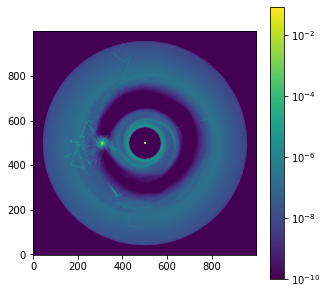

In [3]:
# Plot fits image
fig = plt.figure(figsize=(5,5))
image = sourceimg

cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(image, origin="lower", cmap=cmap, norm=LogNorm(vmin=1e-10))

plt.colorbar()
print("size of the image:", image.shape)
print("range of the image:", image.max(),"and", image.min())

In [4]:
# Read spectrum (function from radmc3dpy)
def readSpectrum(fname='', old=False):
    if fname.strip() == '':
        fname = 'spectrum.out'

    with open(fname, 'r') as rfile:
        # Read the format number
        dum = rfile.readline()
        # Read the number of wavelengths
        nwav = int(rfile.readline())
        # Read a blank line
        dum = rfile.readline()

        res = np.zeros([nwav, 2], dtype=np.float64)
        for iwav in range(nwav):
            dum = rfile.readline().split()
            res[iwav, 0] = float(dum[0])
            res[iwav, 1] = float(dum[1])
    return res

spectrum = readSpectrum("spectrum.out")
lam = spectrum[:,0]
spec = spectrum[:,1] * 1e23       # Conversion from erg s-1 cm-2 Hz-1 to Jy


In [14]:
# Check image pixel scale
try:
    pixscale = sourcehdr['CDELT1'] * -3600
except:
    pixscale = sourcehdr['CD1_1'] * -3600
print("Pixel scale:", pixscale, "arcsec/pixel")

Pixel scale: 0.00260003475982296 arcsec/pixel


In [6]:
# Convert flux level (adapted from SIMMetis example notebook)
from astropy import units as u
lam_ref = 10 * u.um
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                         equivalencies=u.spectral_density(lam_ref))
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, flam_ref))

dlam = lam[1]-lam[0]  # [um], spectral bin width
flux = np.ones_like(lam) * flam_ref * dlam

1 Jy at 10.00 um corresponds to 1509190.18 ph / (m2 s um)


In [8]:
# Creating the source
src_disk = source_from_image(image, lam, flux, # spectra
                                    plate_scale=pixscale, # The plate scale of the simulated image
                                    ) 


In [9]:
# Runing the simulation with two hours of exposure time
t_long = 3600 * 2  # second
t_short = 2 
sim_image_2h = simcado.run(src_disk, OBS_NDIT=1, OBS_DIT=t_long)
sim_image_2s = simcado.run(src_disk, OBS_NDIT=1, OBS_DIT=t_short)


Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 7200    NDIT = 1
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 3 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 2    NDIT = 1


Text(0.5, 1.0, 'OBS_DIT=2')

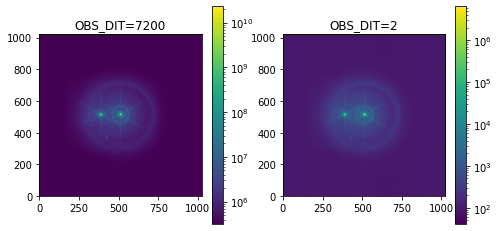

In [10]:
extent = (xmin, xmax, ymin, ymax) = (400, 625, 400, 625)

#extent = (xmin, xmax, ymin, ymax) = (300, 800, 300, 800)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
im1=ax1.imshow(sim_image_2h[0].data, norm=LogNorm(),origin="lower")
im2=ax2.imshow(sim_image_2s[0].data, norm=LogNorm(), origin='lower')
fig.colorbar(im1, ax=ax1)
ax1.set_title("OBS_DIT=7200")
fig.colorbar(im2, ax=ax2)
ax2.set_title("OBS_DIT=2")

In [11]:
print('pixel scale is', sim_image_2s[0].header['CDELT1'] * 3600 * 1000, 'mas/pix')

pixel scale is 3.99999999999996 mas/pix


In [174]:
sim_image_2h.writeto("MICADO_2h.fits", overwrite=True)